In [3]:
# All imports go here

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# TURN THIS OFF IF ITS MESSING ANYTHING UP
pd.set_option('display.max_columns', None)

#Cleaning the Data

0. Read csv into a df

In [4]:
city_market_df = pd.read_csv('sample_file.csv')

1. Before cleaning the data, edit the DF so that periods of time can be seen as years and months instead.

In [5]:
# Make 'period_begin' datetime object
city_market_df['period_begin'] = pd.to_datetime(city_market_df['period_begin'])

# Make a new col called 'Month' and use 'period_begin'
months = city_market_df['period_begin'].dt.month_name().values
city_market_df['month'] = months

# Create new col 'year' with 'period_begin'
years = city_market_df['period_begin'].dt.year.values
city_market_df['year'] = years

# Move year after month
cols = ['month'] + ['year'] + [col for col in city_market_df.columns if col != 'month' or 'year']
city_market_df = city_market_df[cols]

2. Remove uncessary columns from the DF

In [6]:
# Drop cols with 'mom' or 'yoy', as they are uneccessary
city_market_df = city_market_df.drop(columns=[
    col for col in city_market_df.columns if 'mom' in col.lower() or 'yoy' in col.lower()])

# Drop remaining cols that aren't needed
city_market_df = city_market_df.drop(columns=['period_begin','period_end','period_duration','region_type',
                             'region_type_id','table_id','is_seasonally_adjusted','median_ppsf',
                             'median_list_ppsf','off_market_in_two_weeks','last_updated'])

city_market_df = city_market_df.iloc[:, :-2]  # Drop the last two columns, as they are redudant

3. Checkpoint. Saving the semi-cleaned DF into a CSV for version control.

In [7]:
city_market_df.to_csv('semi-clean_sample_file.csv', index=False)

4. Read new csv into another df.

In [8]:
semi_clean_df = pd.read_csv('semi-clean_sample_file.csv')

Note: This the initial amount of NaNs in the data. We will be dealing with them and outliers shortly.

In [9]:
# Finding NaN values
# Finding the number of NaN values
print(semi_clean_df.isna().sum())

month                                0
year                                 0
region                               0
city                                 0
state                                0
state_code                           0
property_type                        0
property_type_id                     0
median_sale_price                   17
median_list_price                 3302
homes_sold                          16
pending_sales                     2039
new_listings                      3328
inventory                         1486
months_of_supply                  1284
median_dom                         243
avg_sale_to_list                   659
sold_above_list                    118
price_drops                       9356
parent_metro_region                  0
parent_metro_region_metro_code       0
dtype: int64


5. Snice the 'month_of_supply & and 'median_dom' cols barely have any NaNs, we will consider dropping them for simplicity.

In [10]:
# Drop all rows where 'month_of_supply' is NaN. Do the same for 'median_dom'

semi_clean_df = semi_clean_df[semi_clean_df['months_of_supply'].notna()]
semi_clean_df = semi_clean_df[semi_clean_df['median_dom'].notna()]

6. We will drop outliers from all  cols and then replace them with NaNs. After, using a groupby operation on the 'state' and 'property_type' cols, we shall update all NaNs with the mean for each column. This way, there will be no NaNs

In [11]:
# This replaces all outliers with NaNs and then all NaNs with the groupby mean of what we agreed on.

columns = ['median_sale_price', 'median_list_price', 'pending_sales', 'new_listings', 'inventory', 'avg_sale_to_list', 'sold_above_list', 'price_drops']

for col in columns:
    # Calculate z-score
    semi_clean_df[col + '_zscore'] = (semi_clean_df[col] - semi_clean_df[col].mean()) / semi_clean_df[col].std()

    # Replace outliers with NaN
    semi_clean_df.loc[(semi_clean_df[col + '_zscore'] < -3) | (semi_clean_df[col + '_zscore'] > 3), col] = np.nan

    # Replace NaN with the mean of the column within the group (grouped by 'state' and 'property_type')
    semi_clean_df[col] = (
        semi_clean_df
        .groupby(['state', 'property_type'])[col]
        .transform(lambda x: x.fillna(x.mean()))
    )

    # Drop the z-score column
    semi_clean_df.drop(columns=[col + '_zscore'], inplace=True)



#Some rows will still contain NaNs. That is because these rows lack values in all instances of their groupby.
#For example, prices from Ohio that have a propetty type -1 will have empty values, therefore the groupby operation will not clear those NaNs.
semi_clean_df = semi_clean_df.dropna()

# Display the updated DataFrame
semi_clean_df


month  year            region          city          state  \
0           June  2015         Moore, OK         Moore       Oklahoma   
2       February  2014        Steger, IL        Steger       Illinois   
3      September  2017      Rockport, AR      Rockport       Arkansas   
4        January  2019     Footville, WI     Footville      Wisconsin   
5         August  2018     Cedarburg, WI     Cedarburg      Wisconsin   
...          ...   ...               ...           ...            ...   
19995     August  2013       Dresden, TN       Dresden      Tennessee   
19996      March  2014    Gang Mills, NY    Gang Mills       New York   
19997   February  2023   New Bedford, MA   New Bedford  Massachusetts   
19998    January  2018  Port Hueneme, CA  Port Hueneme     California   
19999    October  2022       Alafaya, FL       Alafaya        Florida   

      state_code              property_type  property_type_id  \
0             OK            All Residential                -1   
2             IL            All Residential                -1   
3             AR  Single Family Residential                 6   
4             WI            All Residential                -1   
5             WI  Single Family Residential                 6   
...          ...                        ...               ...   
19995         TN  Single Family Residential                 6   
19996         NY  Single Family Residential                 6   
19997         MA  Single Family Residential                 6   
19998         CA            All Residential                -1   
19999         FL  Single Family Residential                 6   

       median_sale_price  median_list_price  homes_sold  pending_sales  \
0               147000.0           149950.0       104.0          118.0   
2                62300.0            36500.0        11.0           13.0   
3               155000.0            65000.0         1.0            1.0   
4               150000.0           294300.0         1.0            2.0   
5               363100.0           406950.0        19.0           16.0   
...                  ...                ...         ...            ...   
19995            93000.0            19900.0         2.0            2.0   
19996           185000.0           239900.0         7.0            7.0   
19997           370000.0           349900.0        29.0           42.0   
19998           343000.0           397500.0        21.0           22.0   
19999           499000.0           447000.0        59.0           43.0   

       new_listings  inventory  months_of_supply  median_dom  \
0             140.0      320.0               3.1        28.0   
2              11.0       54.0               4.9        50.0   
3               1.0        2.0               2.0        26.0   
4               1.0        4.0               4.0       119.0   
5              11.0       36.0               1.9        70.0   
...             ...        ...               ...         ...   
19995           1.0        4.0               2.0        64.0   
19996           9.0       26.0               3.7       187.0   
19997          32.0       49.0               1.7        35.0   
19998          18.0       40.0               1.9        44.0   
19999          49.0      116.0               2.0        28.0   

       avg_sale_to_list  sold_above_list  price_drops parent_metro_region  \
0              0.980668         0.182692     0.259375   Oklahoma City, OK   
2              0.967177         0.272727     0.203704         Chicago, IL   
3              1.000000         0.000000     0.209653         Malvern, AR   
4              0.938086         0.000000     0.202503      Janesville, WI   
5              0.977062         0.210526     0.277778       Milwaukee, WI   
...                 ...              ...          ...                 ...   
19995          0.842628         0.000000     0.202309          Martin, TN   
19996          0.931512         0.000000     0.230562         Corning, NY   
19

Final Check for NaN

In [12]:
print(semi_clean_df.isna().sum())

month                             0
year                              0
region                            0
city                              0
state                             0
state_code                        0
property_type                     0
property_type_id                  0
median_sale_price                 0
median_list_price                 0
homes_sold                        0
pending_sales                     0
new_listings                      0
inventory                         0
months_of_supply                  0
median_dom                        0
avg_sale_to_list                  0
sold_above_list                   0
price_drops                       0
parent_metro_region               0
parent_metro_region_metro_code    0
dtype: int64


7. Further cleaning, we drop rows that will not be useful to the models we will train.

In [13]:
# Remove cols that have value associated with categorical data, these were kept in for readability, but now are uncessary.

semi_clean_df = semi_clean_df.drop(columns=['region', 'state_code', 'property_type_id', 'parent_metro_region_metro_code'])
semi_clean_df

month  year          city          state  \
0           June  2015         Moore       Oklahoma   
2       February  2014        Steger       Illinois   
3      September  2017      Rockport       Arkansas   
4        January  2019     Footville      Wisconsin   
5         August  2018     Cedarburg      Wisconsin   
...          ...   ...           ...            ...   
19995     August  2013       Dresden      Tennessee   
19996      March  2014    Gang Mills       New York   
19997   February  2023   New Bedford  Massachusetts   
19998    January  2018  Port Hueneme     California   
19999    October  2022       Alafaya        Florida   

                   property_type  median_sale_price  median_list_price  \
0                All Residential           147000.0           149950.0   
2                All Residential            62300.0            36500.0   
3      Single Family Residential           155000.0            65000.0   
4                All Residential           150000.0           294300.0   
5      Single Family Residential           363100.0           406950.0   
...                          ...                ...                ...   
19995  Single Family Residential            93000.0            19900.0   
19996  Single Family Residential           185000.0           239900.0   
19997  Single Family Residential           370000.0           349900.0   
19998            All Residential           343000.0           397500.0   
19999  Single Family Residential           499000.0           447000.0   

       homes_sold  pending_sales  new_listings  inventory  months_of_supply  \
0           104.0          118.0         140.0      320.0               3.1   
2            11.0           13.0          11.0       54.0               4.9   
3             1.0            1.0           1.0        2.0               2.0   
4             1.0            2.0           1.0        4.0               4.0   
5            19.0           16.0          11.0       36.0               1.9   
...           ...            ...           ...        ...               ...   
19995         2.0            2.0           1.0        4.0               2.0   
19996         7.0            7.0           9.0       26.0               3.7   
19997        29.0           42.0          32.0       49.0               1.7   
19998        21.0           22.0          18.0       40.0               1.9   
19999        59.0           43.0          49.0      116.0               2.0   

       median_dom  avg_sale_to_list  sold_above_list  price_drops  \
0            28.0          0.980668         0.182692     0.259375   
2            50.0          0.967177         0.272727     0.203704   
3            26.0          1.000000         0.000000     0.209653   
4           119.0          0.938086         0.000000     0.202503   
5            70.0          0.977062         0.210526     0.277778   
...           ...               ...              ...          ...   
19995        64.0          0.842628         0.000000     0.202309   
19996       187.0          0.931512         0.000000     0.230562   
19997        35.0          0.999130         0.551724     0.244898   
19998        44.0          0.989166         0.428571     0.200000   
19999        28.0          0.986246         0.220339     0.327586   

      parent_metro_region  
0       Oklahoma City, OK  
2             Chicago, IL  
3             Malvern, AR  
4          Janesville, WI  
5           Milwaukee, WI  
...                   ...  
19995          Martin, TN  
19996         Corning, NY  
19997      Providence, RI  
19998          Oxnard, CA  
19999         Orlando, FL  

[18399 rows x 17 columns]

#Visualization

1. create a copy of the cleaned df to do visualizations on

In [14]:
visualize_df = semi_clean_df.copy()

2. boxplot - median sales price by property type

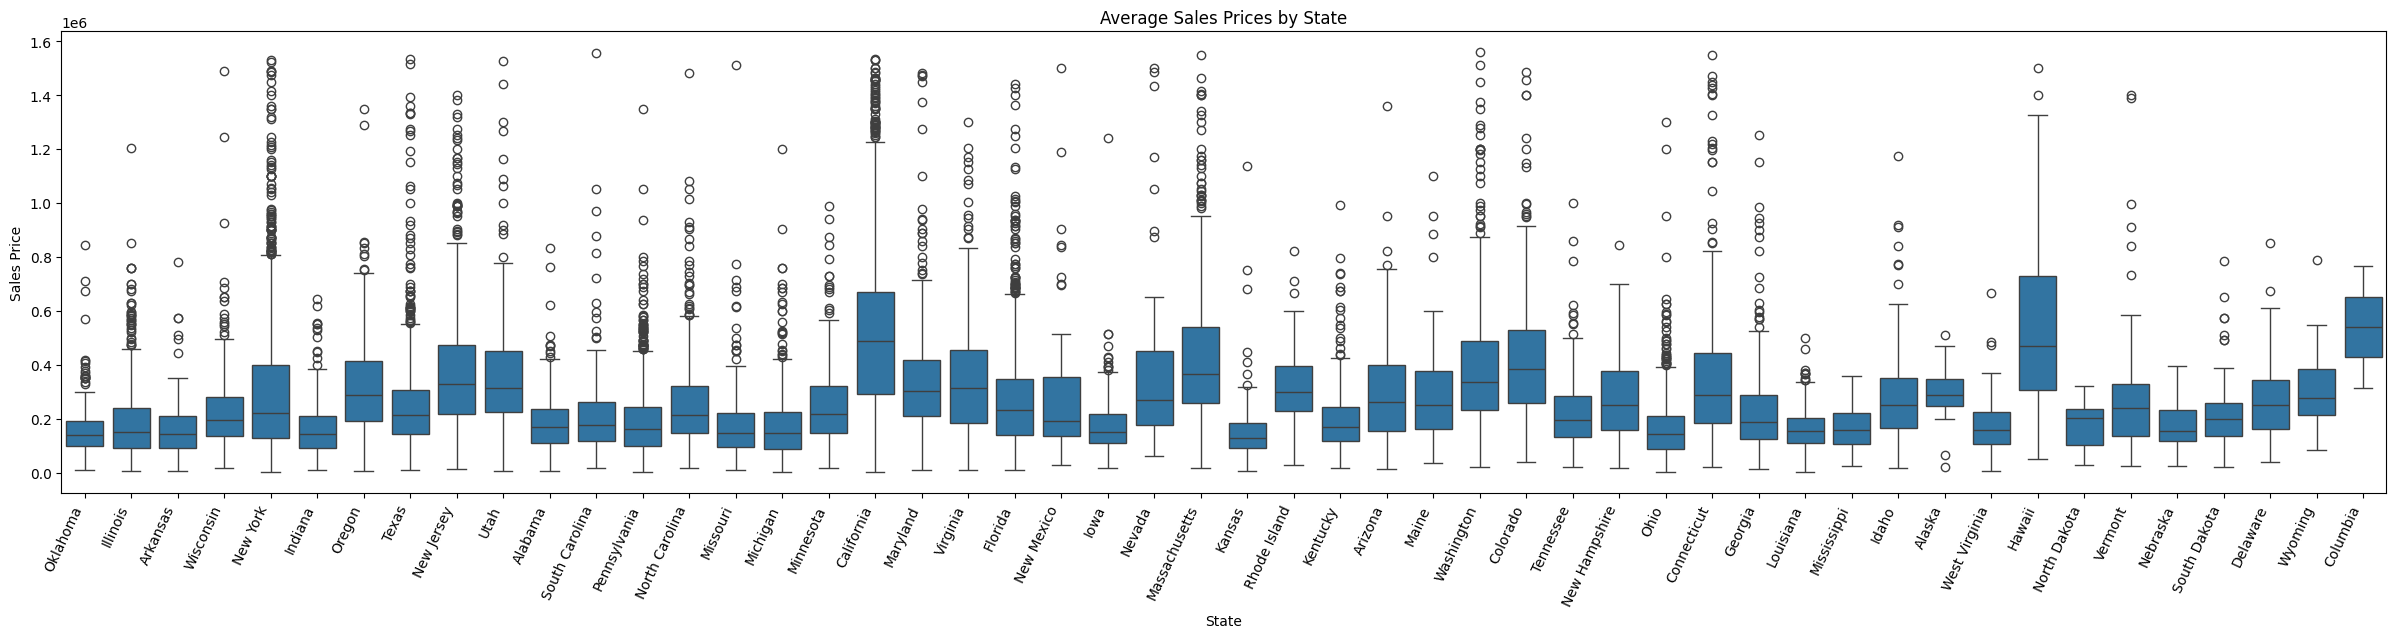

In [15]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='state', y='median_sale_price', data=visualize_df)
plt.xlabel('State')
plt.ylabel('Sales Price')
plt.xticks(rotation=65, ha='right')
plt.title('Average Sales Prices by State')
plt.show()

2. Bar Graph - number of homes_sold by property type

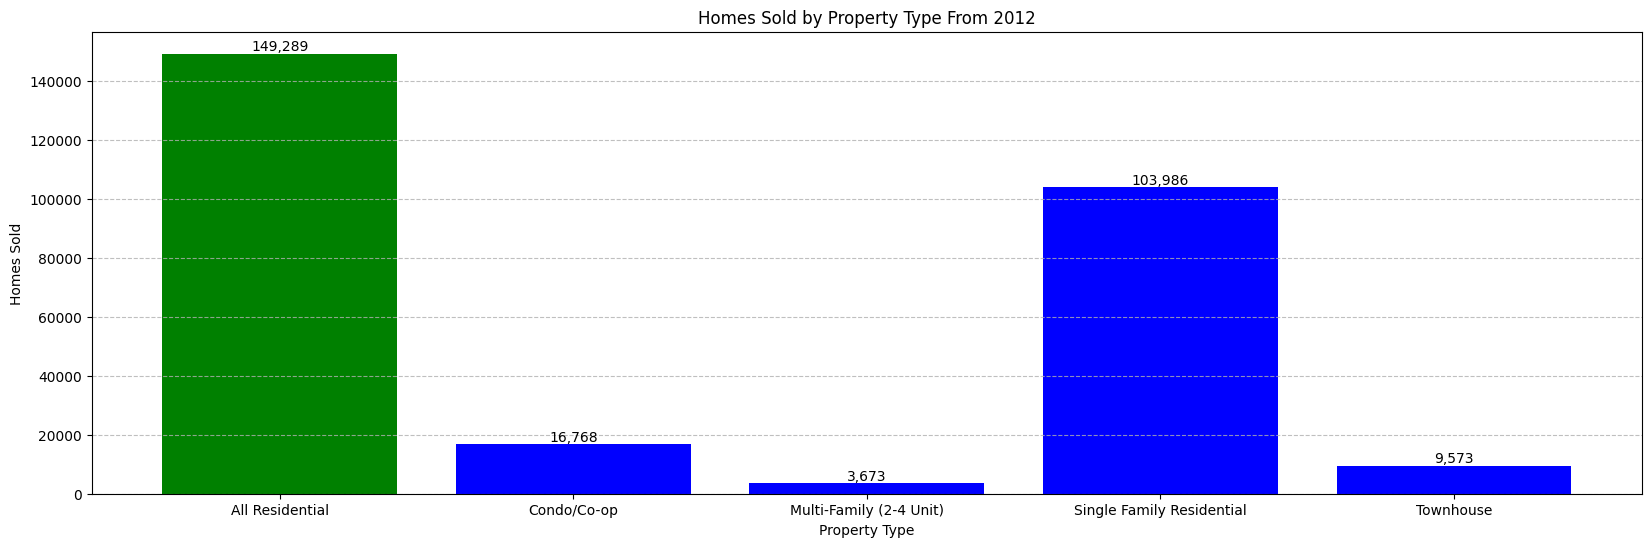

In [16]:
plt.figure(figsize=(20, 6))

nums = visualize_df.groupby('property_type', as_index=False)['homes_sold'].sum()

#All Residental is gonna be used as a general control
c = ['blue'] * len(nums)
for i, property in enumerate(nums['property_type']):
    if property == 'All Residential':
        c[i] = 'green'

bars = plt.bar(nums['property_type'], nums['homes_sold'], color=c)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height):,}",
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Property Type')
plt.ylabel('Homes Sold')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.title('Homes Sold by Property Type From 2012')
plt.show()

3. Correlation Heat Map

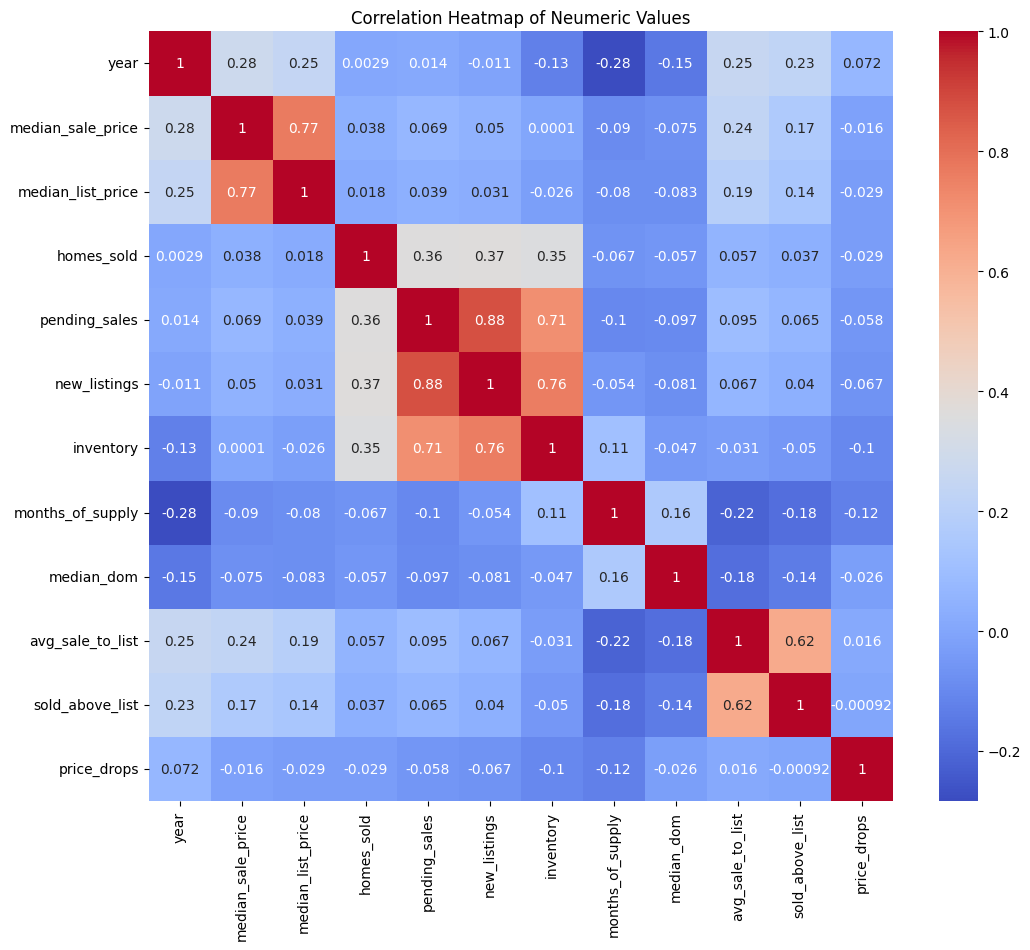

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(visualize_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Neumeric Values")
plt.show()

4. Line Graph- Yearly inventory by month

<ipython-input-18-78df158a7bee>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = copy.groupby(['year', 'month'], as_index=False)['inventory'].sum()


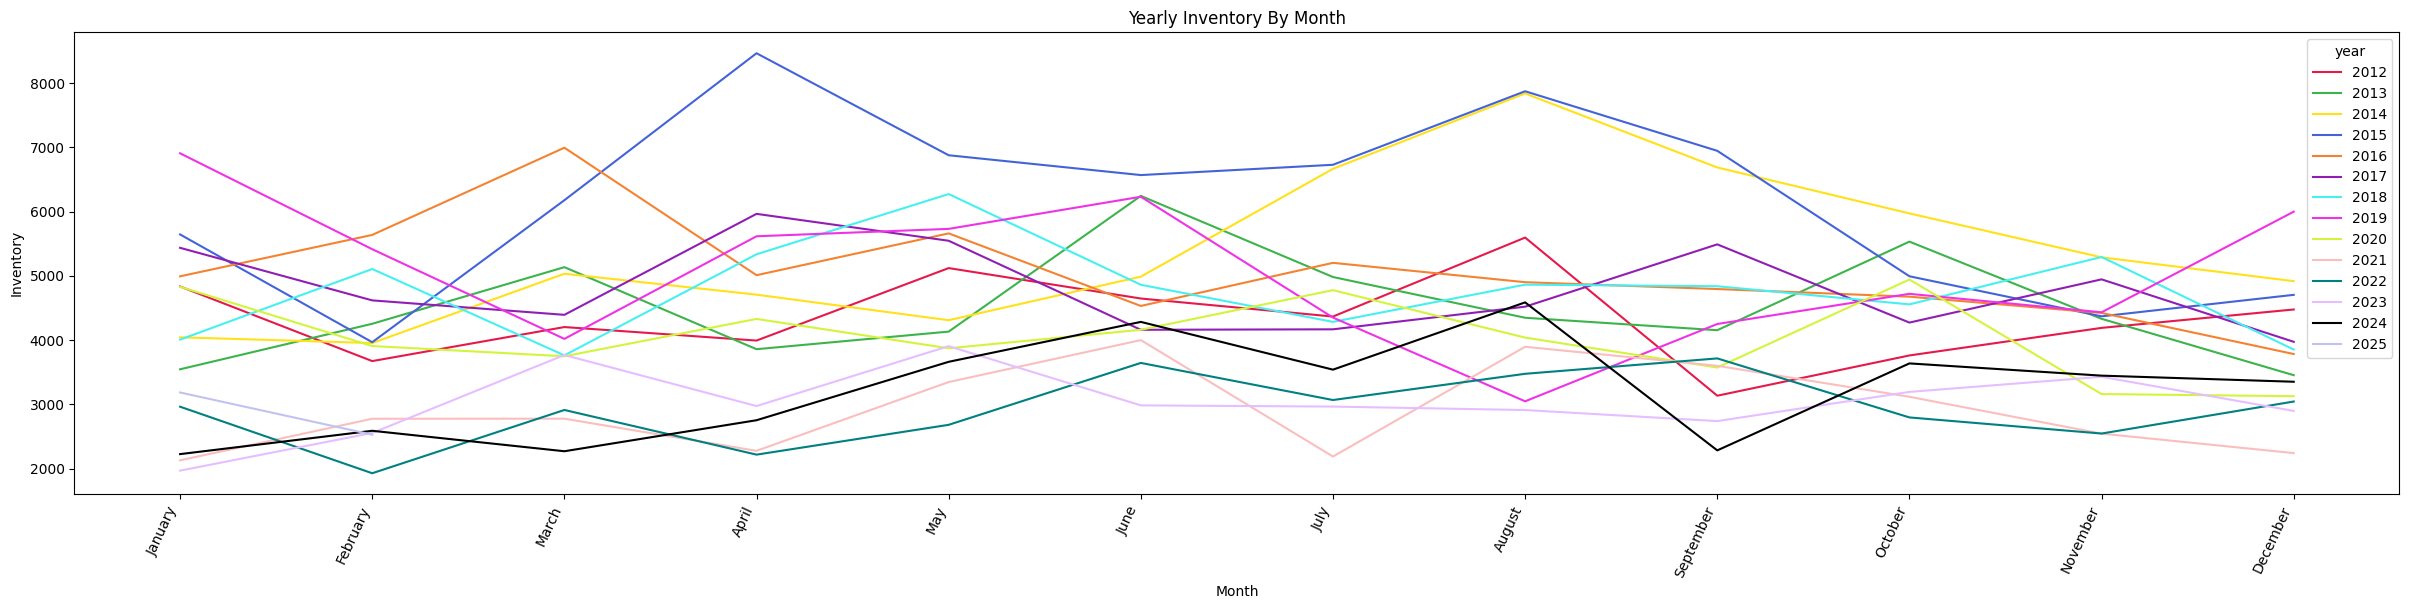

In [18]:
from functools import total_ordering
plt.figure(figsize=(30, 6))

copy = visualize_df.copy() #copying the df to avoid making changes to it
#set month order so it's by year
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
copy['month'] = pd.Categorical(copy['month'], categories=month_order, ordered=True)
total = copy.groupby(['year', 'month'], as_index=False)['inventory'].sum()
copy = pd.merge(copy, total, on=['year', 'month'], how='left')

#define a color palette with more distinctive colors so it's easier to see years on graph
palette = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8',  '#f58231',  '#911eb4', '#46f0f0',
           '#f032e6',  '#d2f53c', '#fabebe', '#008080', '#e6beff',  '000000', '#c2c2f0']

sns.lineplot(x='month', y='inventory_y', hue="year", data=copy, palette=palette, errorbar=None)

plt.xlabel('Month')
plt.ylabel('Inventory')
plt.xticks(rotation=65, ha='right')
plt.title('Yearly Inventory By Month')
plt.show()

#One Hot Encoding

In [19]:
#Begin OHE
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

#select the categorical cols to ohe
cols = ['month', 'city', 'state', 'property_type','parent_metro_region']

ohetransform = ohe.fit_transform(semi_clean_df[cols])
semi_clean_df = pd.concat([semi_clean_df, ohetransform], axis= 1).drop(columns=cols)

In [20]:
semi_clean_df

year  median_sale_price  median_list_price  homes_sold  pending_sales  \
0      2015           147000.0           149950.0       104.0          118.0   
2      2014            62300.0            36500.0        11.0           13.0   
3      2017           155000.0            65000.0         1.0            1.0   
4      2019           150000.0           294300.0         1.0            2.0   
5      2018           363100.0           406950.0        19.0           16.0   
...     ...                ...                ...         ...            ...   
19995  2013            93000.0            19900.0         2.0            2.0   
19996  2014           185000.0           239900.0         7.0            7.0   
19997  2023           370000.0           349900.0        29.0           42.0   
19998  2018           343000.0           397500.0        21.0           22.0   
19999  2022           499000.0           447000.0        59.0           43.0   

       new_listings  inventory  months_of_supply  median_dom  \
0             140.0      320.0               3.1        28.0   
2              11.0       54.0               4.9        50.0   
3               1.0        2.0               2.0        26.0   
4               1.0        4.0               4.0       119.0   
5              11.0       36.0               1.9        70.0   
...             ...        ...               ...         ...   
19995           1.0        4.0               2.0        64.0   
19996           9.0       26.0               3.7       187.0   
19997          32.0       49.0               1.7        35.0   
19998          18.0       40.0               1.9        44.0   
19999          49.0      116.0               2.0        28.0   

       avg_sale_to_list  sold_above_list  price_drops  month_April  \
0              0.980668         0.182692     0.259375          0.0   
2              0.967177         0.272727     0.203704          0.0   
3              1.000000         0.000000     0.209653          0.0   
4              0.938086         0.000000     0.202503          0.0   
5              0.977062         0.210526     0.277778          0.0   
...                 ...              ...          ...          ...   
19995          0.842628         0.000000     0.202309          0.0   
19996          0.931512         0.000000     0.230562          0.0   
19997          0.999130         0.551724     0.244898          0.0   
19998          0.989166         0.428571     0.200000          0.0   
19999          0.986246         0.220339     0.327586          0.0   

       month_August  month_December  month_February  month_January  \
0               0.0             0.0             0.0            0.0   
2               0.0             0.0             1.0            0.0   
3               0.0             0.0             0.0            0.0   
4               0.0             0.0             0.0            1.0   
5               1.0             0.0             0.0            0.0   
...             ...             ...             ...            ...   
19995           1.0             0.0             0.0            0.0   
19996           0.0             0.0             0.0            0.0   
19997           0.0             0.0             1.0            0.0   
19998           0.0             0.0             0.0            1.0   
19999           0.0             0.0             0.0            0.0   

       month_July  month_June  month_March  month_May  month_November  \
0             0.0         1.0          0.0        0.0             0.0   
2             0.0         0.0          0.0        0.0             0.0   
3             0.0         0.0          0.0        0.0             0.0   
4             0.0         0.0          0.0        0.0             0.0   
5             0.0         0.0          0.0        0.0             0.0   
...           ...         ...          ...        ...             ...   
19995         0.0         0.0          0.0        0.0             0.0   
19996      

In [21]:
#Saving final df to a csv

semi_clean_df.to_csv('cleaned_sample.csv', index=False)

# Linear Regression

1. With Cities Data

In [22]:
from sklearn.linear_model import LinearRegression

# Load the cleaned dataset
df = pd.read_csv('cleaned_sample.csv')

# Set target and features
y = df['median_sale_price']  # Target
X = df.drop(columns=['median_sale_price'])  # All other columns are features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate performance
print("Predictions:", predictions[:5])
print("R² Score:", r2_score(y_test, predictions))
print("MSE:", mean_squared_error(y_test, predictions))

Predictions: [680794.60723032 281725.37845873 188487.46776954 111655.10059854
 224241.8709083 ]
R² Score: 0.5340817335842172
MSE: 25256507935.660988


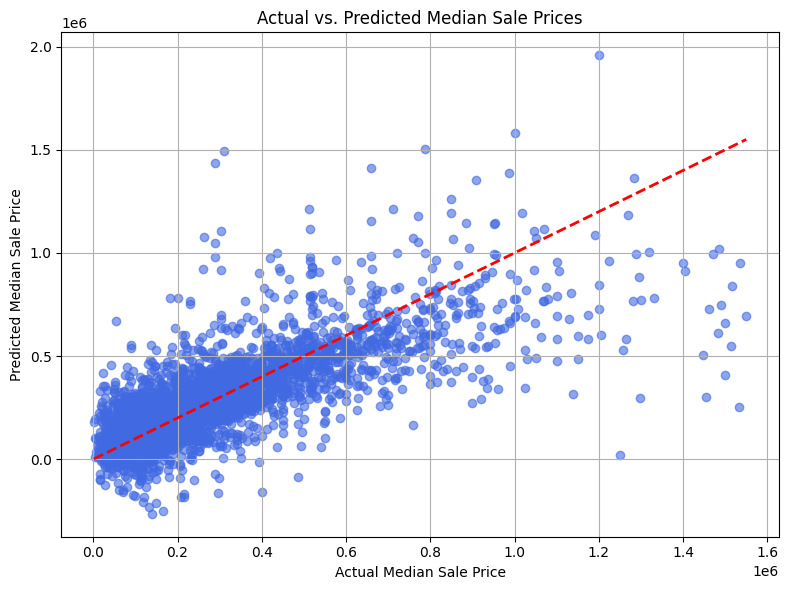

In [23]:
# Scatter plot of actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x line

plt.xlabel('Actual Median Sale Price')
plt.ylabel('Predicted Median Sale Price')
plt.title('Actual vs. Predicted Median Sale Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

2. Without Cities Data

In [24]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_sample.csv')

# Set target
y = df['median_sale_price']

# Set features and exclude city-related columns
X = df.drop(columns=['median_sale_price'])
X = X.loc[:, ~X.columns.str.startswith('city_')]  # drop one-hot city columns
X = X.drop(columns=['city'], errors='ignore')     # drop raw city column if it exists

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate performance
print("Predictions:", predictions[:5])
print("R² Score:", r2_score(y_test, predictions))
print("MSE:", mean_squared_error(y_test, predictions))

Predictions: [725268.45061864 302913.87636138 162630.2054036  270192.94307784
 244824.91713616]
R² Score: 0.64724784193033
MSE: 19121996972.01303


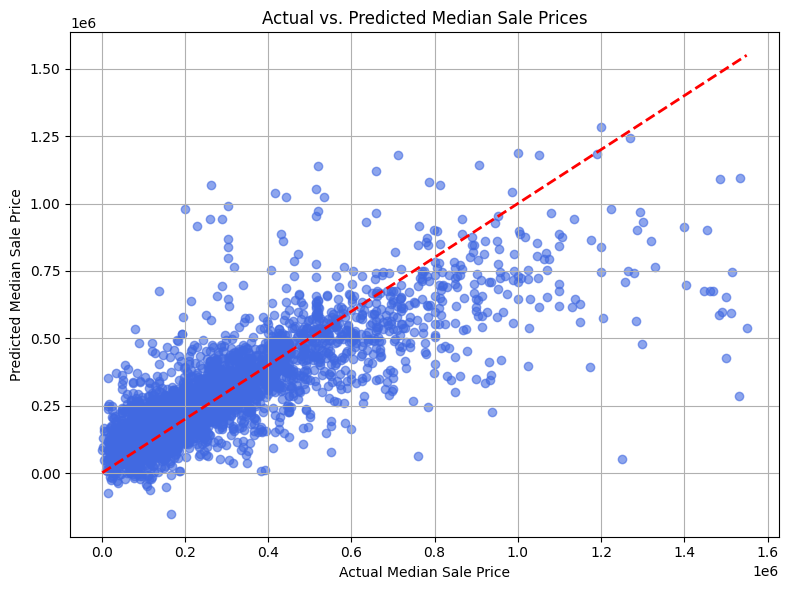

In [25]:
# Scatter plot of actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x line

plt.xlabel('Actual Median Sale Price')
plt.ylabel('Predicted Median Sale Price')
plt.title('Actual vs. Predicted Median Sale Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest Regressor

1. With Cities Data

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Load cleaned data
df = pd.read_csv('cleaned_sample.csv')

# Define target and features
y = df['median_sale_price']
X = df.drop(columns=['median_sale_price'])

# Train-test split (no scaling needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_predictions = rf_model.predict(X_test)

# Evaluate
print("R²:", r2_score(y_test, rf_predictions))
print("MSE:", mean_squared_error(y_test, rf_predictions))

R²: 0.6630185418240824
MSE: 18267098515.07631


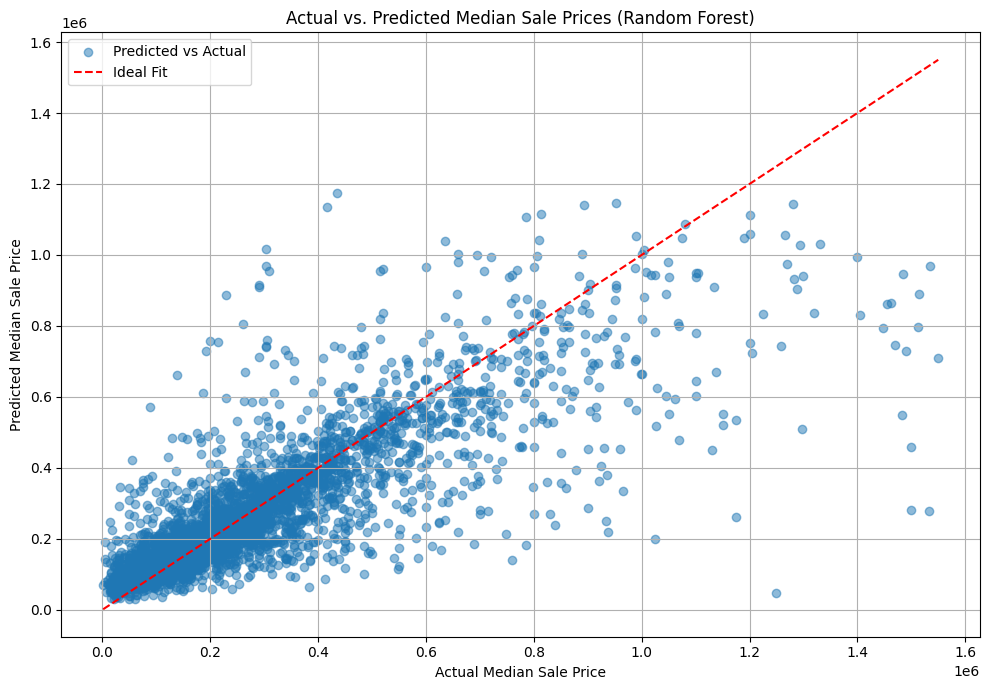

In [28]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 7))
plt.scatter(y_test, rf_predictions, alpha=0.5, label='Predicted vs Actual')

# Add a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')

# Labels and title
plt.xlabel('Actual Median Sale Price')
plt.ylabel('Predicted Median Sale Price')
plt.title('Actual vs. Predicted Median Sale Prices (Random Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2. Without Cities Data

In [29]:
# Load cleaned data
df = pd.read_csv('cleaned_sample.csv')

# Define features and exclude city-related columns
X = df.drop(columns=['median_sale_price'])
X = X.loc[:, ~X.columns.str.startswith('city_')]  # remove one-hot city columns
X = X.drop(columns=['city'], errors='ignore')     # drop raw city column if present

# Train-test split (no scaling needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_predictions = rf_model.predict(X_test)

# Evaluate
print("R²:", r2_score(y_test, rf_predictions))
print("MSE:", mean_squared_error(y_test, rf_predictions))

R²: 0.6663627395228362
MSE: 18085816170.499542


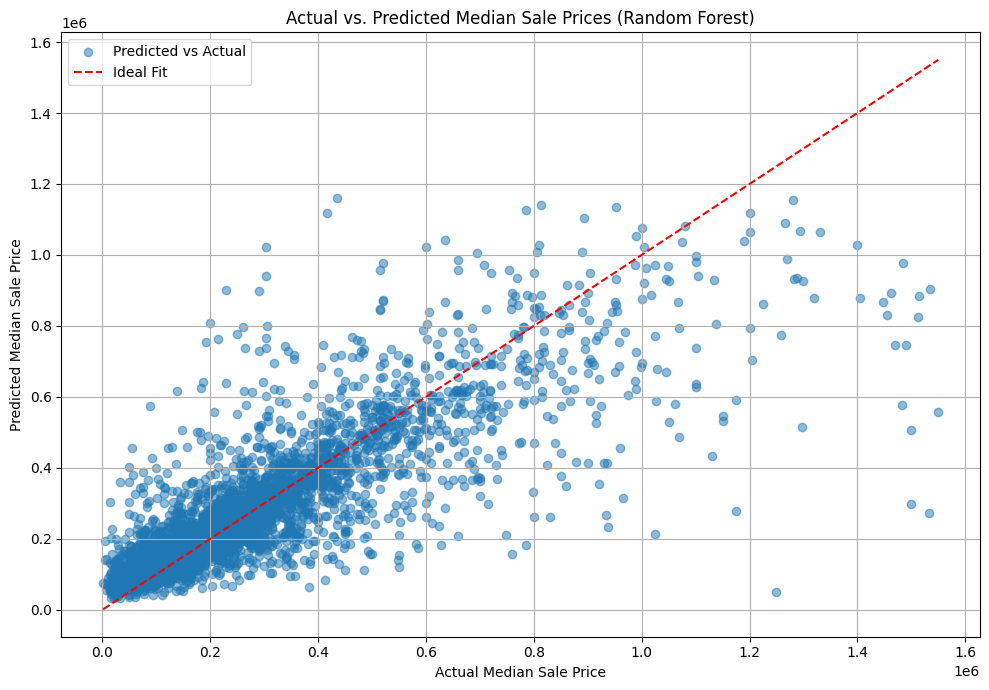

In [30]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 7))
plt.scatter(y_test, rf_predictions, alpha=0.5, label='Predicted vs Actual')

# Add a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')

# Labels and title
plt.xlabel('Actual Median Sale Price')
plt.ylabel('Predicted Median Sale Price')
plt.title('Actual vs. Predicted Median Sale Prices (Random Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notes: Linear regression performs better without cities while random forest regressor performs better with cities. Maybe we could talk about this


# Logarithmic Regression

1. With Cities

In [31]:
from sklearn.linear_model import LogisticRegression

# Define binary target
df['sold_above'] = (df['median_sale_price'] > df['median_list_price']).astype(int)

# Define X and y
X = df.drop(columns=['median_sale_price', 'median_list_price', 'sold_above'])
y = df['sold_above']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6282608695652174
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      2301
           1       0.51      0.25      0.34      1379

    accuracy                           0.63      3680
   macro avg       0.58      0.55      0.54      3680
weighted avg       0.60      0.63      0.59      3680



2. Without Cities

In [32]:
# Define binary target
df['sold_above'] = (df['median_sale_price'] > df['median_list_price']).astype(int)

# Define full X and y
X = df.drop(columns=['median_sale_price', 'median_list_price', 'sold_above'])
y = df['sold_above']

# Exclude city-related columns just for logistic regression
X = X.loc[:, ~X.columns.str.startswith('city_')]
X = X.drop(columns=['city'], errors='ignore')

# Split and train as usual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6331521739130435
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2301
           1       0.53      0.22      0.31      1379

    accuracy                           0.63      3680
   macro avg       0.59      0.55      0.53      3680
weighted avg       0.61      0.63      0.59      3680



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Seems like cities dont do much for log reg unless I did something wrong